# Heatmap/Hittable over Latitudes from Ferrybox

In this notebook, we 

1. Load ferrybox data from a single journey from the MS Color Fantasy
2. Create latitude grid in the Oslofjord
3. Map cholorphyll measurements from the ferrybox into the target grid

We do this for a multiple journeys.

This gives us a (timespace) heatmap.

## Preliminaries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import tqdm
import warnings

## Load Data, Define Oslofjord Grid, Populate the Hittable

In [3]:
# setup target coords
lat_lo = 59.4
lat_hi = 59.95
lat_range = np.mgrid[lat_lo:lat_hi:64j]

# target dates
dates = pd.date_range(start='2024-05-01', end='2024-08-14', freq='2D')

In [4]:
# load ferrybox trajectories
def _load_trajectories(tlo, thi):
    url = "https://thredds.niva.no/thredds/dodsC/datasets/nrt/color_fantasy.nc"
    ds = xr.open_dataset(url, engine='netcdf4')
    ds = ds.sel(time=slice(tlo, thi))
    # find nearest corresponding cell in the target grid
    # isn't this code we already have in nwp-utils???
    return ds.latitude.values, ds.chlorophyll.values
    
lats, chl = _load_trajectories(dates[0], dates[1])

In [5]:
def _map_measurements(source_coords, source_measurements, target_coords):
    # target_measurements = len(target_coords) * [ [ ] ]  # DON'T DO THIS, cf. https://stackoverflow.com/q/41770791/21124232
    target_measurements = [[] for _ in range(len(target_coords))]
    for kk in range(len(source_coords)):
        source_coord = source_coords[kk]
        source_measurement = source_measurements[kk]
        idx = np.argmin(np.abs(target_coords - source_coord))
        target_measurements[idx].append(source_measurement)
    return target_measurements
    
chl_on_lat_range = _map_measurements(lats, chl, lat_range)
chl_on_lat_range = [ np.mean(x) for x in chl_on_lat_range ]  # average

/Users/volkerh/miniforge3/envs/iliad/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/volkerh/miniforge3/envs/iliad/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
chl_hittable = []
for kdate in tqdm.tqdm(range(len(dates)-1)):
    tlo = dates[kdate]
    thi = dates[kdate+1]
    lats, chl = _load_trajectories(tlo, thi)
    chl_on_lat_range_single = _map_measurements(lats, chl, lat_range)
    # https://stackoverflow.com/a/29688390/21124232
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        chl_on_lat_range_single = [ np.median(x) for x in chl_on_lat_range_single ]  # median
    chl_hittable.append(chl_on_lat_range_single)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:58<00:00,  1.13s/it]


In [7]:
chl_hittable = np.array(chl_hittable)

## Show Results, Hittables for two Journeys

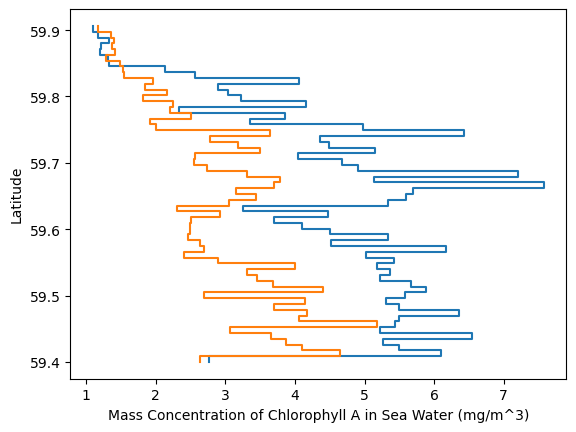

In [8]:
plt.step(chl_hittable[0,:], lat_range)
plt.step(chl_hittable[1,:], lat_range)
plt.ylabel('Latitude')
plt.xlabel('Mass Concentration of Chlorophyll A in Sea Water (mg/m^3)')
pass

## Show Results, Timespace Heatmap

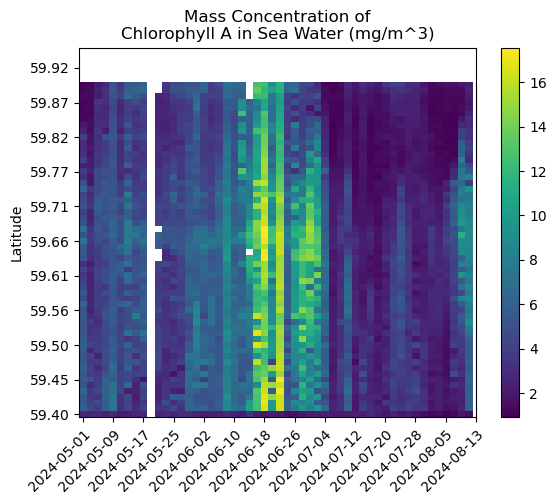

In [9]:
fig, ax = plt.subplots(1,1)
cb = ax.imshow(chl_hittable.T, aspect='auto', origin='lower')
plt.colorbar(cb)

# time labels
ax.set_xticks(np.mgrid[0:len(dates):4])
# ax.set_xticklabels(dates[np.mgrid[0:len(dates):4]])
ax.set_xticklabels(dates[np.mgrid[0:len(dates):4]].strftime('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# latitude labels
ax.set_yticks(np.mgrid[0:len(lat_range):6])
ax.set_yticklabels([ "%.2f" % lat for lat in lat_range[np.mgrid[0:len(lat_range):6]]])
ax.set_ylabel('Latitude')

ax.set_title('Mass Concentration of\nChlorophyll A in Sea Water (mg/m^3)')

pass